Intra Option Q Learning

Learning the options simultaneously

In [41]:


import numpy as np
from tqdm import tqdm
import random
import gym
import glob
import io
import matplotlib.pyplot as plt

In [42]:
seed = 543
#Setting up the environment
env = gym.make('Taxi-v3')
env.reset(seed=seed)

state_shape = env.observation_space.shape
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state,"state")
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, terminated, truncated, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state,"nextstate")
print(reward)
print(terminated)
print(truncated)
print(info)
print("----")

()
6
3
----
(328, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}) state
----
4
----
328 nextstate
-10
False
False
{'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
----


e:\python\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [43]:
RED_ACTN_MATRIX = np.array([[1,3,0,0,0],
[1,3,0,0,0],
[1,3,3,3,3],
[1,1,1,1,1],
[1,1,1,1,1]])

GRE_ACTN_MATRIX = np.array([[0,0,2,2,1],
[0,0,2,2,1],
[2,2,2,2,1],
[1,1,1,1,1],
[1,1,1,1,1]])

YEL_ACTN_MATRIX = np.array([[0,0,0,0,0],
[0,0,0,0,0],
[0,3,3,3,3],
[0,1,1,1,1],
[0,1,1,1,1]])

BLU_ACTN_MATRIX = np.array([[0,0,0,0,3],
[0,0,0,0,3],
[2,2,2,0,3],
[1,1,1,0,3],
[1,1,1,0,3]])

RED_TERM_MATRIX = np.zeros((5,5)); RED_TERM_MATRIX[0,0] = 1
GRE_TERM_MATRIX = np.zeros((5,5)); GRE_TERM_MATRIX[0,4] = 1
YEL_TERM_MATRIX = np.zeros((5,5)); YEL_TERM_MATRIX[4,0] = 1
BLU_TERM_MATRIX = np.zeros((5,5)); BLU_TERM_MATRIX[4,3] = 1
OPT_TO_POLICY_MAP = {6 : RED_ACTN_MATRIX, 7 : GRE_ACTN_MATRIX, 8 :
YEL_ACTN_MATRIX, 9 : BLU_ACTN_MATRIX}
OPT_TO_TERM_MAP = {6 : RED_TERM_MATRIX, 7 : GRE_TERM_MATRIX, 8 :YEL_TERM_MATRIX, 9 : BLU_TERM_MATRIX}

In [44]:
def Drive_to_R(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = RED_ACTN_MATRIX[coords[0], coords[1]]
    if (coords == [0, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def Drive_to_G(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = GRE_ACTN_MATRIX[coords[0], coords[1]]
    if (coords == [0, 4]): # termination at reaching GREEN
        optdone = True
    return [optact, optdone]

def Drive_to_Y(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = YEL_ACTN_MATRIX[coords[0], coords[1]]
    if (coords == [4, 0]): # termination at reaching YELLOW
        optdone = True
    return [optact, optdone]

def Drive_to_B(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = BLU_ACTN_MATRIX[coords[0], coords[1]]
    if (coords == [4, 3]): # termination at reaching BLUE
        optdone = True
    return [optact, optdone]

In [45]:
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_IOQL = np.zeros((500,10))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9

#Update_Frequency Data structure? Check TODO 4
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#avl_actions = [6, 7, 8, 9]
# TODO: epsilon-greedy action selection function
def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [46]:
def learn_R(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [0, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_G(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [0, 4]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_Y(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [4, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_B(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [4, 3]): # termination at reaching RED
        optdone = True
    return [optact, optdone]



In [47]:
def ioql(alpha,epsilon):
    episode_rewards = []
    gamma = 0.9
    q_values_IOQL = np.zeros((500,10))
    R_option_policy=np.zeros((25,4)) 
    G_option_policy=np.zeros((25,4))  
    B_option_policy=np.zeros((25,4)) 
    Y_option_policy=np.zeros((25,4)) 
    for _ in tqdm(range(5000)):
        
        state, _ = env.reset()   
        
        done = False
        total_reward = 0  
        while not done:
            st_coords = tuple(env.decode(state))[:2]
            dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
            dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
            action = egreedy_policy(q_values_IOQL, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
            if action < 6:
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                q_values_IOQL[state][action] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state][action])
                update_frequency[state][action] += 1
                state = next_state
                total_reward += reward 
            reward_bar = 0
            s_state = state
            if action == 6: 
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_R(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                    update_frequency[state, optact] += 1
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    options_to_update = [action]
                    st_coords = list(env.decode(state))[:2]
                    other_options = [7,8,9]
                    for oth in other_options:
                        if oth == 7:
                            pa,pd = learn_G(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 8:
                            pa,pd = learn_Y(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 9:
                            pa,pd = learn_B(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                    nst_coords = list(env.decode(next_state))[:2]
                    for opt in options_to_update:
                            term_matrix = OPT_TO_TERM_MAP[opt]
                            if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                            else:
                                # if it does not, we use the option q-value in next state for update
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                    state = next_state

                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                total_reward += reward_bar 
            if action == 7: 
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_G(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                    update_frequency[state, optact] += 1
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    options_to_update = [action]
                    st_coords = list(env.decode(state))[:2]
                    other_options = [6,8,9]
                    for oth in other_options:
                        if oth == 6:
                            pa,pd = learn_R(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 8:
                            pa,pd = learn_Y(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 9:
                            pa,pd = learn_B(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                    nst_coords = list(env.decode(next_state))[:2]
                    for opt in options_to_update:
                            term_matrix = OPT_TO_TERM_MAP[opt]
                            if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                            else:
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                    state = next_state

                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                total_reward += reward_bar  
            if action == 8: 
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_Y(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                    update_frequency[state, optact] += 1
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    options_to_update = [action]
                    st_coords = list(env.decode(state))[:2]
                    other_options = [6,7,9]
                    for oth in other_options:
                        if oth == 6:
                            pa,pd = learn_R(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 7:
                            pa,pd = learn_G(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 9:
                            pa,pd = learn_B(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                    nst_coords = list(env.decode(next_state))[:2]
                    for opt in options_to_update:
                            term_matrix = OPT_TO_TERM_MAP[opt]
                            if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                                # if the option terminates, we do total max over all actions(and options) in next state
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                            else:
                                # if it does not, we use the option q-value in next state for update
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                    state = next_state

                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                total_reward += reward_bar  

            if action == 9: 
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_B(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                    update_frequency[state, optact] += 1
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    options_to_update = [action]
                    st_coords = list(env.decode(state))[:2]
                    other_options = [6,7,8]
                    for oth in other_options:
                        if oth == 6:
                            pa,pd = learn_R(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 7:
                            pa,pd = learn_G(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                        if oth == 8:
                            pa,pd = learn_Y(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                    nst_coords = list(env.decode(next_state))[:2]
                    for opt in options_to_update:
                            term_matrix = OPT_TO_TERM_MAP[opt]
                            if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                            else:
                                q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                                update_frequency[state, opt] += 1
                    state = next_state

                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                total_reward += reward_bar  
            if done:
                episode_rewards.append(total_reward) 
    return sum(episode_rewards[4000:])

In [48]:
from bayes_opt import BayesianOptimization
param_space = {
   
    'alpha': (0.1, 0.7),
    'epsilon': (0.02, 0.25),
}
optimizer = BayesianOptimization(
    f=ioql,
    pbounds=param_space,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   |   alpha   |  epsilon  |
-------------------------------------------------


100%|██████████| 5000/5000 [00:17<00:00, 288.63it/s]


| 1         | 7.873e+03 | 0.3502    | 0.1857    |


100%|██████████| 5000/5000 [00:27<00:00, 179.43it/s]


| 2         | 7.855e+03 | 0.1001    | 0.08954   |


100%|██████████| 5000/5000 [00:34<00:00, 144.27it/s]


| 3         | 7.98e+03  | 0.1881    | 0.04124   |


100%|██████████| 5000/5000 [00:28<00:00, 176.06it/s]


| 4         | 7.864e+03 | 0.2118    | 0.09948   |


100%|██████████| 5000/5000 [00:20<00:00, 239.30it/s]


| 5         | 7.853e+03 | 0.3381    | 0.1439    |


100%|██████████| 5000/5000 [00:26<00:00, 189.66it/s]


| 6         | 7.847e+03 | 0.1838    | 0.02765   |


100%|██████████| 5000/5000 [00:19<00:00, 257.59it/s]


| 7         | 8.012e+03 | 0.598     | 0.1718    |


100%|██████████| 5000/5000 [00:22<00:00, 221.10it/s]


| 8         | 7.838e+03 | 0.1896    | 0.1646    |


100%|██████████| 5000/5000 [00:24<00:00, 206.77it/s]


| 9         | 7.951e+03 | 0.1516    | 0.1945    |


100%|██████████| 5000/5000 [00:17<00:00, 280.58it/s]


| 10        | 7.897e+03 | 0.3374    | 0.05714   |


100%|██████████| 5000/5000 [00:16<00:00, 308.47it/s]


| 11        | 7.872e+03 | 0.6326    | 0.1229    |


100%|██████████| 5000/5000 [00:17<00:00, 282.76it/s]


| 12        | 7.982e+03 | 0.3594    | 0.101     |


100%|██████████| 5000/5000 [00:16<00:00, 296.13it/s]


| 13        | 7.96e+03  | 0.4659    | 0.1104    |


100%|██████████| 5000/5000 [00:16<00:00, 299.85it/s]


| 14        | 7.934e+03 | 0.4319    | 0.1815    |


100%|██████████| 5000/5000 [00:20<00:00, 245.24it/s]


| 15        | 7.837e+03 | 0.1891    | 0.1135    |


100%|██████████| 5000/5000 [00:22<00:00, 223.40it/s]


| 16        | 8.073e+03 | 0.1401    | 0.1429    |


100%|██████████| 5000/5000 [00:17<00:00, 282.18it/s]


| 17        | 7.904e+03 | 0.3035    | 0.08323   |


100%|██████████| 5000/5000 [00:19<00:00, 256.63it/s]


| 18        | 8.052e+03 | 0.2146    | 0.1749    |


100%|██████████| 5000/5000 [00:16<00:00, 308.15it/s]


| 19        | 8.006e+03 | 0.6459    | 0.1157    |


100%|██████████| 5000/5000 [00:19<00:00, 254.89it/s]

| 20        | 7.804e+03 | 0.2008    | 0.1773    |


In [49]:
print(optimizer.max)

{'target': 8073.0, 'params': {'alpha': 0.1400844438047716, 'epsilon': 0.14288597991937635}}


In [50]:
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_IOQL = np.zeros((500,10))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9

#Update_Frequency Data structure? Check TODO 4
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#avl_actions = [6, 7, 8, 9]
# TODO: epsilon-greedy action selection function
def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm is a library for displaying progress bars

# Initialize episode_rewards list to store rewards obtained during each episode
episode_rewards = []

# Add parameters you might need here
gamma = 0.9
alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]
# Iterate over 1000 episodes
for _ in tqdm(range(500000)):
    
    state, _ = env.reset()   
    #print(state)
    done = False
    total_reward = 0  # Initialize total reward for the episode

    # While episode is not over
    while not done:
       
        
        # Choose action  
        st_coords = tuple(env.decode(state))[:2]
        
        dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
        action = egreedy_policy(q_values_IOQL, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        #print(action,st_coords,"hello")
        #action = egreedy_policy(q_values_IOQL, state, epsilon)
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_IOQL[state][action] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward  # Accumulate reward for the episode
        
        # Checking if action chosen is an option
        reward_bar = 0
        s_state = state
        if action == 6: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_R(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                update_frequency[state, optact] += 1
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                options_to_update = [action]
                st_coords = list(env.decode(state))[:2]
                other_options = [7,8,9]
                for oth in other_options:
                    if oth == 7:
                        pa,pd = learn_G(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 8:
                        pa,pd = learn_Y(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 9:
                        pa,pd = learn_B(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                nst_coords = list(env.decode(next_state))[:2]
                for opt in options_to_update:
                        term_matrix = OPT_TO_TERM_MAP[opt]
                        if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                            # if the option terminates, we do total max over all actions(and options) in next state
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                        else:
                            # if it does not, we use the option q-value in next state for update
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                state = next_state

                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            #q_values_IOQL[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_IOQL[next_state]) - q_values_IOQL[s_state][6])
            #update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode

        # Update state for other option actions (similar to action 6)
        if action == 7: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_G(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                update_frequency[state, optact] += 1
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                options_to_update = [action]
                st_coords = list(env.decode(state))[:2]
                other_options = [6,8,9]
                for oth in other_options:
                    if oth == 6:
                        pa,pd = learn_R(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 8:
                        pa,pd = learn_Y(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 9:
                        pa,pd = learn_B(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                nst_coords = list(env.decode(next_state))[:2]
                for opt in options_to_update:
                        term_matrix = OPT_TO_TERM_MAP[opt]
                        if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                            # if the option terminates, we do total max over all actions(and options) in next state
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                        else:
                            # if it does not, we use the option q-value in next state for update
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                state = next_state

                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            #q_values_IOQL[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_IOQL[next_state]) - q_values_IOQL[s_state][6])
            #update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode

        if action == 8: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_Y(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                update_frequency[state, optact] += 1
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                options_to_update = [action]
                st_coords = list(env.decode(state))[:2]
                other_options = [6,7,9]
                for oth in other_options:
                    if oth == 6:
                        pa,pd = learn_R(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 7:
                        pa,pd = learn_G(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 9:
                        pa,pd = learn_B(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                nst_coords = list(env.decode(next_state))[:2]
                for opt in options_to_update:
                        term_matrix = OPT_TO_TERM_MAP[opt]
                        if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                            # if the option terminates, we do total max over all actions(and options) in next state
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                        else:
                            # if it does not, we use the option q-value in next state for update
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                state = next_state

                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            #q_values_IOQL[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_IOQL[next_state]) - q_values_IOQL[s_state][6])
            #update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode

        if action == 9: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_B(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                q_values_IOQL[state, optact] += alpha * (reward + gamma*np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, optact])
                update_frequency[state, optact] += 1
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                options_to_update = [action]
                st_coords = list(env.decode(state))[:2]
                other_options = [6,7,8]
                for oth in other_options:
                    if oth == 6:
                        pa,pd = learn_R(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 7:
                        pa,pd = learn_G(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                    if oth == 8:
                        pa,pd = learn_Y(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                nst_coords = list(env.decode(next_state))[:2]
                for opt in options_to_update:
                        term_matrix = OPT_TO_TERM_MAP[opt]
                        if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                            # if the option terminates, we do total max over all actions(and options) in next state
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                        else:
                            # if it does not, we use the option q-value in next state for update
                            q_values_IOQL[state, opt] += alpha * (reward + gamma * (q_values_IOQL[next_state, opt]) - q_values_IOQL[state, opt])
                            update_frequency[state, opt] += 1
                state = next_state

                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            #q_values_IOQL[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_IOQL[next_state]) - q_values_IOQL[s_state][6])
            #update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode


        # Check if episode is done
        if done:
            episode_rewards.append(total_reward)  # Append total reward for the episode

# Plot rewards vs. episodes



        

100%|██████████| 500000/500000 [22:23<00:00, 372.25it/s]


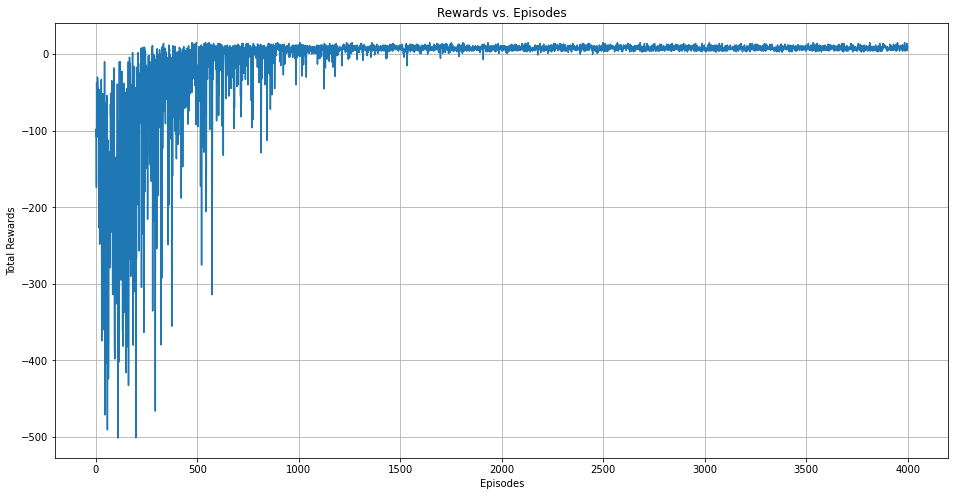

In [57]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,4000 + 1), episode_rewards[:4000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [58]:
def visualize_q_values(q_values, msg, pass_src = None, pass_dest = None):
    assert(pass_src != None and pass_dest != None)

    req_actions = [[None for _ in range(5)] for _ in range(5)]
    req_q_values = [[None for _ in range(5)] for _ in range(5)]
    temp_env = gym.make('Taxi-v3')
    for s in range(500):
        s_vec = list(temp_env.decode(s))
        if s_vec[2] == pass_src and s_vec[3] == pass_dest:
            req_actions[s_vec[0]][s_vec[1]] = np.argmax(q_values[s])
            req_q_values[s_vec[0]][s_vec[1]] = np.max(q_values[s])
    req_actions = np.array(req_actions)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(msg)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Columns')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Rows')
    mesh = ax.pcolormesh(req_q_values, edgecolors='k', linewidths=2)
    fig.colorbar(mesh)
    def x_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [0, 1]:
            return 0
        return 1 if a == 2 else -1
    def y_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [2, 3]:
            return 0
        return 1 if a == 1 else -1
    idx = np.indices((5,5))
    policyx = np.vectorize(x_direct)(req_actions)
    policyy = np.vectorize(y_direct)(req_actions)
    req_action_dict = {4 : 'Pickup', 5 : 'Drop', 6 : 'R', 7 : 'G', 8 : 'Y', 9 : 'B'}
    for i,j,px,py in zip(idx[1].ravel(), idx[0].ravel(), policyx.ravel(), policyy.ravel()):
        if (req_actions[j, i] < 4):
            ax.quiver(i+0.5, j+0.5, px, py, pivot="middle", scale=10,color='red')
        else:
            ax.text(i+0.5, j+0.5, req_action_dict[req_actions[j][i]], horizontalalignment='center',verticalalignment='center',color='tomato')
    

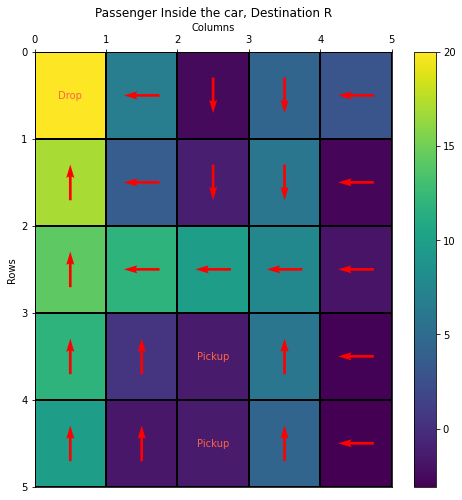

In [65]:
visualize_q_values(q_values_IOQL, "Passenger Inside the car, Destination R", 4, 0)

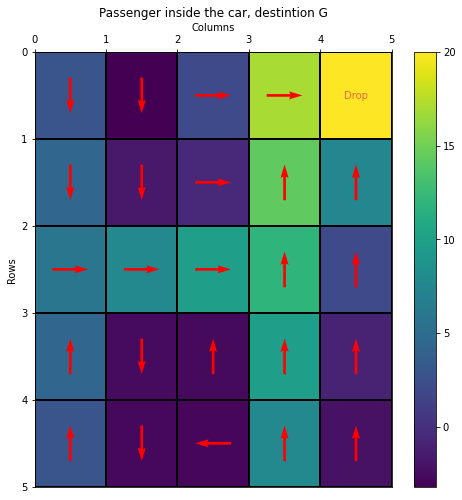

In [66]:
visualize_q_values(q_values_IOQL, "Passenger inside the car, destintion G",  4, 1)

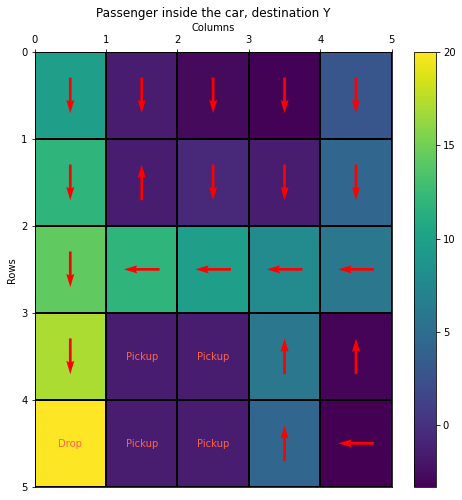

In [67]:
visualize_q_values(q_values_IOQL, "Passenger inside the car, destination Y",  4, 2)

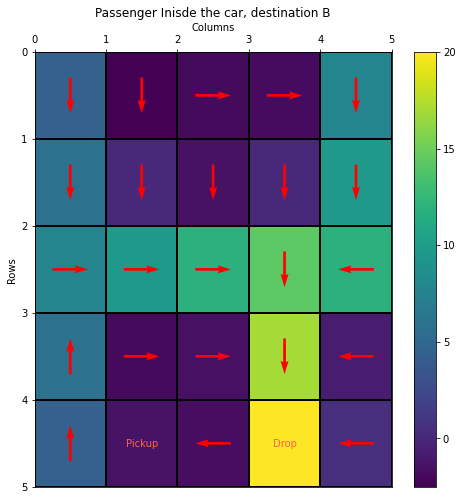

In [68]:
visualize_q_values(q_values_IOQL, "Passenger Inisde the car, destination B",  4, 3)

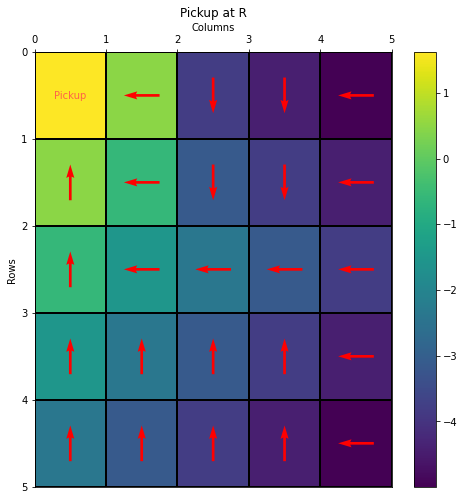

In [69]:
visualize_q_values(q_values_IOQL, "Pickup at R",  0, 1)

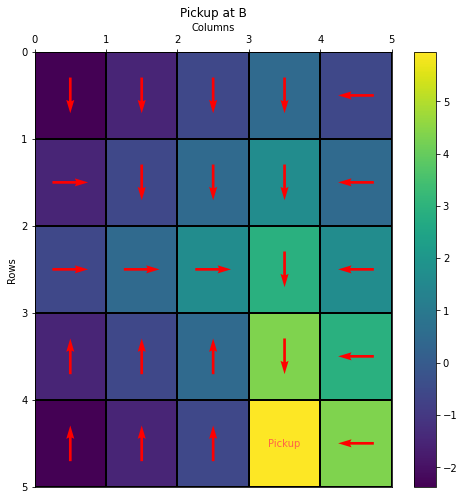

In [73]:
visualize_q_values(q_values_IOQL, "Pickup at B",  3, 1)

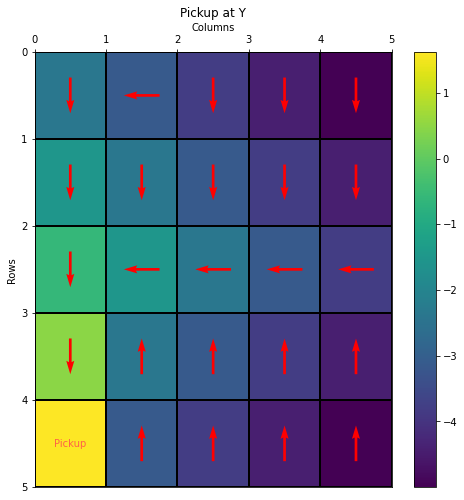

In [70]:
visualize_q_values(q_values_IOQL, "Pickup at Y", 2, 1)